<img src="https://avatars.githubusercontent.com/u/61354833" align="left" width="70" height="70">

Code by [TomMakesThings](https://tommakesthings.github.io/Movie-Genre-Predictor/)

# **About**
This notebook is an individual bit of work I created as part of a group coursework. The aim of the project being to create a multi-label classifier that can predict the genre of film descriptions from IMDb. To find out more, visit https://tommakesthings.github.io/Movie-Genre-Predictor/.

The purpose of this notebook is to explore different NLP techniques such as: normalization, tokenization, stop word removal, stemming, lemmatization, multi-hot encoding, word vector embedding and classification through a neural network. Rather than experimenting with the whole dataset, an LSTM classifier is created and trained over 5000 randomly selected samples. As a result, the accuracy could be better. However, later into the project the text pre-processing steps and parameters for the classifier were improved and the model converted into a pipeline in another notebook.

# Imports

This notebook has been developed using Python 3.8.5 and <a href="https://www.anaconda.com/">Anaconda3</a> with conda 4.10.1. If you would like to recreate the environment, the YAML file environment.yml can be found on <a href="https://github.com/TomMakesThings/Movie-Genre-Predictor/blob/main/environment.yml">GitHub</a>. Using this, it is possible to recreate the environment using the command `conda env create -f environment.yml` through the Anaconda terminal. For more detail refer to the <a href="https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#activating-an-environment">conda docs</a>.

In [1]:
#!pip install pycontractions
#!pip install pyspellchecker
#!pip install dill

import nltk
#nltk.download('stopwords')

import pandas as pd
import numpy as np
import spacy
import scattertext
import unicodedata
import matplotlib.pyplot as plt
import string
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import random
import seaborn as sns
import math
import re
import dill
import pickle
from termcolor import colored
from sklearn.preprocessing import MultiLabelBinarizer
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from IPython.display import IFrame
from IPython.core.display import display, HTML
from spacy import displacy
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from matplotlib.pyplot import figure

import contractions

from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix

from torchtext.legacy import data

from torch.utils.data import Dataset
from spellchecker import SpellChecker

%matplotlib inline

import gensim.downloader as api

display(HTML("<style>.container { width:98% !important; }</style>"))

C:\Users\Christian\condasom\envs\imdb-lstm-legacy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Christian\AppData\Local\Temp\ipykernel_8380\1297220434.py:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# IMDb Dataset

Open the dataset, drop irrelevent columns and remove samples with missing information.

In [2]:
# Read IMDb dataset
#path = "wiki_movie_plots_deduped.csv"
#dataframe = pd.read_csv(path, low_memory=False)
# Using head()
#dataframe = dataframe.head(10000)

train_plots = np.load('data/X_train.npy', allow_pickle=True).tolist()
train_values = np.load('data/y_train.npy').tolist()

genre_map = {
    1: "action",
    2: "adventure",
    3: "animation",
    4: "comedy",
    5: "crime",
    6: "documentary",
    7: "drama",
    8: "fantasy",
    9: "horror",
    10: "musical",
    11: "mystery",
    12: "romance",
    13: "sci-fi",
    14: "sports",
    15: "thriller"
}

indices = [[i for i, x in enumerate(row) if x == 1] for row in train_values]
#print(indices)
genre_arr = []
for index_arr in indices:
    genre = ""
    for gen in index_arr:
        genre += genre_map.get(gen + 1) + ", "
    genre = genre.strip()
    genre = genre[:-1]
    genre_arr.append(genre)


name_arr = []
for i in range(len(train_plots)):
    name_arr.append(i)
    
print(len(train_plots), len(indices), len(name_arr))
# Read specific columns and drop and rows with NaN values
movies_data = pd.DataFrame({
    'title': name_arr,
    'genre': genre_arr,
    'description': train_plots
}) 
movies_data

18388 18388 18388


,title,genre,description
0,0,horror,october 30 1989 maria rossi suzan crowley comm...
1,1,drama,agnes molly parker alcoholic druguser struggli...
2,2,animation,mammy two shoes stumbles upon entering kitchen...
3,3,thriller,paul hoplin rod steiger mastermind crime colle...
4,4,drama,early 20th century prohibition era approaching...
...,...,...,...
18383,18383,drama,alex 16yearold skateboarder rides freight trai...
18384,18384,drama,vasu n rama rao affluent gentleman doesn’t any...
18385,18385,comedy,nico march deported us government wanting mone...
18386,18386,drama,arthur parker robert mcwade wealthy steel magn...


# Analysing the Dataset

### Metrics

Each film contains between 1 to 3 genres stored in `genre`. However, they are stored in the same column meaning some processing is required to separate each one to count the true number. For example, `Drama`, `Romance` and `Drama, Romance` would be counted as three different genres, even though only two unique genres are present.

In [3]:
def find_unique_genres(data):
    # Search all samples to find the genres types
    all_gens = []
    print(data['genre'])
    for genre_list in data['genre'].apply(lambda genre_list: genre_list.split(", ")):
        # Iterate through genre(s) for each film
        for genre in genre_list:
            # Remove whitespace
            all_gens.append(genre)

    # Create list of all unique genres
    unique_gens = list(set(all_gens))
    unique_gens.sort()
    print(unique_gens)
    #print(all_gens)
    return unique_gens, all_gens
print("Hello")
unique_genres, all_genres = find_unique_genres(movies_data)

Hello
0           horror
1            drama
2        animation
3         thriller
4            drama
           ...    
18383        drama
18384        drama
18385       comedy
18386        drama
18387       comedy
Name: genre, Length: 18388, dtype: object
['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'sports', 'thriller']


Print information about the dataset:
* When running on the full dataset, there are 25 genres in total.
* On average a film belongs to two genres meaning the average sample has two labels.
* Printing the shortest description length revealed that some descriptions do not have an adequate length, e.g. "Slip (", "McAllister (" and "Humble". Therefore a filter is applied later to remove samples where length is less than `min_length`.

In [4]:
tokenizer = RegexpTokenizer(r"\w+")

print(colored("Total number of films in IMDb dataset: ", color="blue", attrs=['bold']) + str(len(movies_data.index)))
print(colored("Number of suitable films (samples): ", color="blue", attrs=['bold']) + str(len(movies_data.index)))
print(colored("Total number of genres (labels): ", color="green", attrs=['bold']) + str(len(all_genres)))
print(colored("Average number of genres per film: ", color="green", attrs=['bold']) + str(len(all_genres) / len(movies_data.index)))
print(colored("Unique genres: ", color="green", attrs=['bold']) + str(unique_genres))
print(colored("Number of unique genres: ", color="green", attrs=['bold']) + str(len(unique_genres)))
print(colored("Average description length: ", color="magenta", attrs=['bold']) + str(np.mean([len(desc) for desc in movies_data.description])))
print(colored("Average number of words in description: ", color="magenta", attrs=['bold']) + str(np.mean([len(tokenizer.tokenize(desc)) for desc in movies_data.description])))
print(colored("Average number of unique words in description: ", color="magenta", attrs=['bold']) + str(np.mean([len(set(tokenizer.tokenize(desc))) for desc in movies_data.description])))
print(colored("Shortest description length: ", color="magenta", attrs=['bold']) + str(min([len(tokenizer.tokenize(desc)) for desc in movies_data.description])))
print(colored("Longest description length: ", color="magenta", attrs=['bold']) + str(max([len(tokenizer.tokenize(desc)) for desc in movies_data.description])))

Total number of films in IMDb dataset: 18388
Number of suitable films (samples): 18388
Total number of genres (labels): 21249
Average number of genres per film: 1.1555906025668914
Unique genres: ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'sports', 'thriller']
Number of unique genres: 15
Average description length: 1519.9502936697847
Average number of words in description: 214.95823363062868
Average number of unique words in description: 152.74929301718512
Shortest description length: 2
Longest description length: 2801


### Graphs

#### Scattertext graph of word occurence between genres

This produces a visual comparision between frequent words from a given genre and all other genres. For example, when `genre = 'Horror'`, the graph shows that words such as 'blood', 'rescue', 'children' appear frequently in horror film descriptions, but infrequently for other genres. These words are therefore useful indicators for identifying this genre. Similarly, words such as 'life' and 'mother' do not commonly appear in horror film descriptions and so their presence indicate a film is unlikely to be horror. Words such as 'film' and 'friends' appear to be common across many genres and so are unlikely to be helpful for identification. These could be removed along with regular stop words such as 'the' and 'of'.

In [5]:
genre = 'comedy' # Set as category to investigate

spacy.prefer_gpu()
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Select 1000 random films to analyse
sample_movies = movies_data.sample(1000, random_state=1)

# Create a scatter text corpus
st_corpus = scattertext.CorpusFromPandas(sample_movies, category_col='genre', text_col='description', nlp=nlp).build()

# Plot graph
#html = scattertext.produce_scattertext_explorer(st_corpus, category=genre, category_name=genre,
                                              #  not_category_name='Other Genre', width_in_pixels=1000,
                                               # minimum_term_frequency=5, metadata=sample_movies['title'])

#file_name = 'Scattertext_' + str(genre) + '.html'
#open(file_name, 'wb').write(html.encode('utf-8'))
#print(colored("Graph of frequent words in " + str(genre).lower() + " films compared to other genres", color="blue", attrs=['bold']))
#IFrame(src=file_name, width=1200, height=700)

#### Word frequency distribution of a given genre

Plot the most common words for a given genre. The first graph includes all words, although is dominated by stop words such as 'a', 'the', 'to'. The second graph has stop words removed. These are more characteristic of the genre, e.g "house" and "killer" for horror. The frequency distribution provide an interesting comparision against topics assigned through unsupervised topic modelling algorithms.

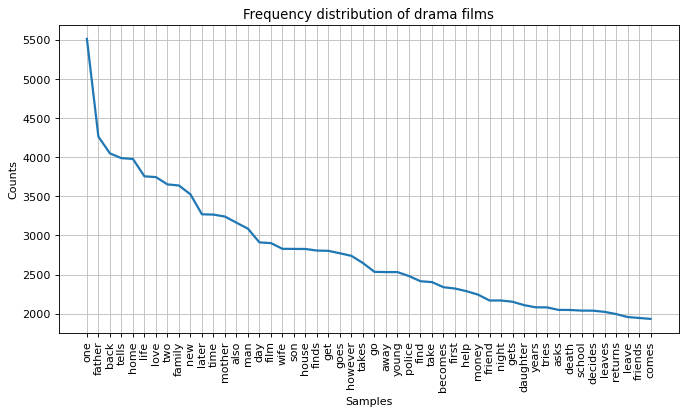

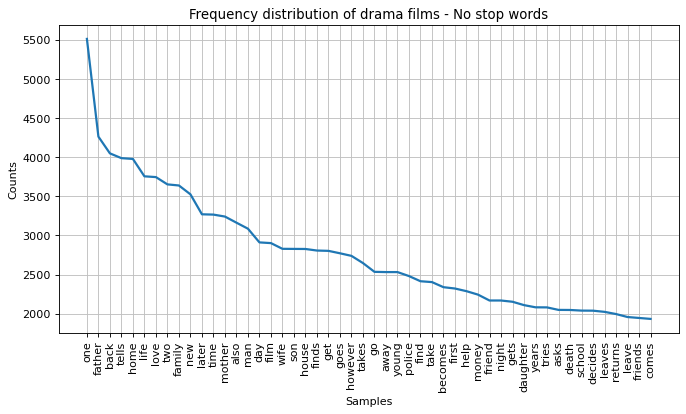

In [6]:
genre = "drama" # Set as category to investigate

film_descs = [] # Descriptions of all films in genre set above

# Iterate through genres + description of each films
for gen, desc in zip(movies_data.genre, movies_data.description):
    # Check if film has desired genre
    if genre in gen.lower():
        # Remove puncuation from description
        for char in string.punctuation:
            desc = desc.replace(char,"")
        # Add tokenized description to list
        film_descs.append(desc.split())

# Plot word frequency distribution
fd = FreqDist(word.lower() for sent in film_descs for word in sent)
figure(figsize=(10, 5), dpi=80)
plt.title("Frequency distribution of " + str(genre) + " films")
fd.plot(50)

# Plot word frequency distribution after removing stop words
figure(figsize=(10, 5), dpi=80)
stop_words = nltk.corpus.stopwords.words('english')
fd_no_stop = FreqDist(word.lower() for sent in film_descs for word in sent if word.lower() not in stop_words)
plt.title("Frequency distribution of " + str(genre) + " films - No stop words")
fd_no_stop.plot(50)
plt.show()

#### N-gram distribution

The first graph below display the most common bigrams across all genres. However, it is dominated by common stop word pairs. As stop words will be removed, I also plotted the most frequent bigrams after removing stop words. This reveals common characters such as "young man", "best friend" and "serial killer", as well as common places such as "high school" and "new york".

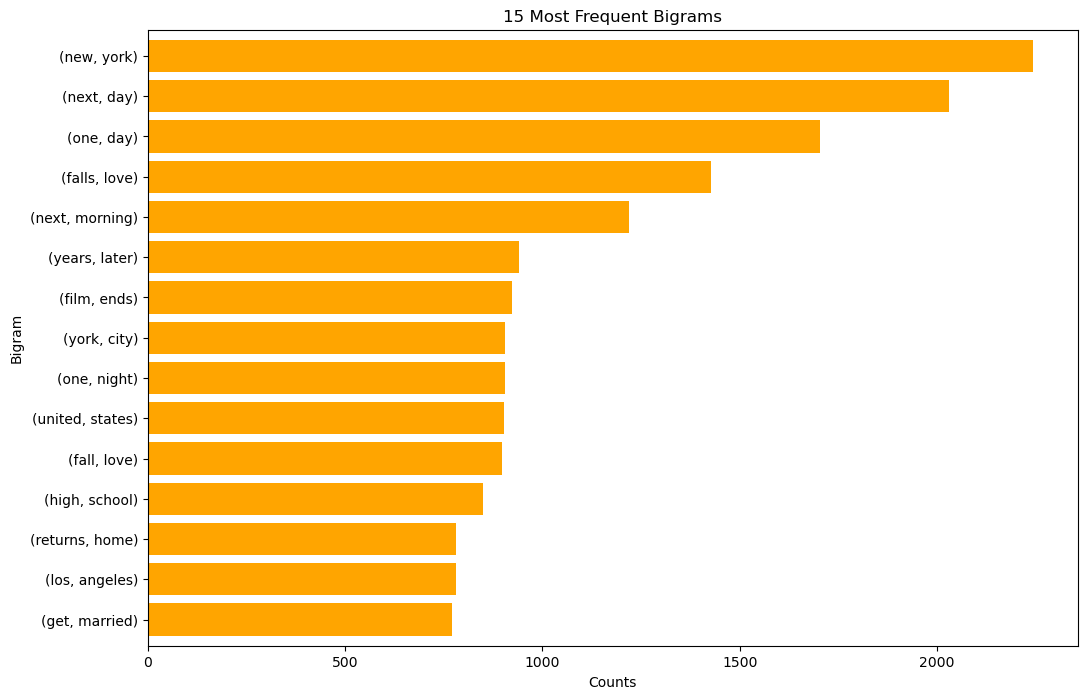

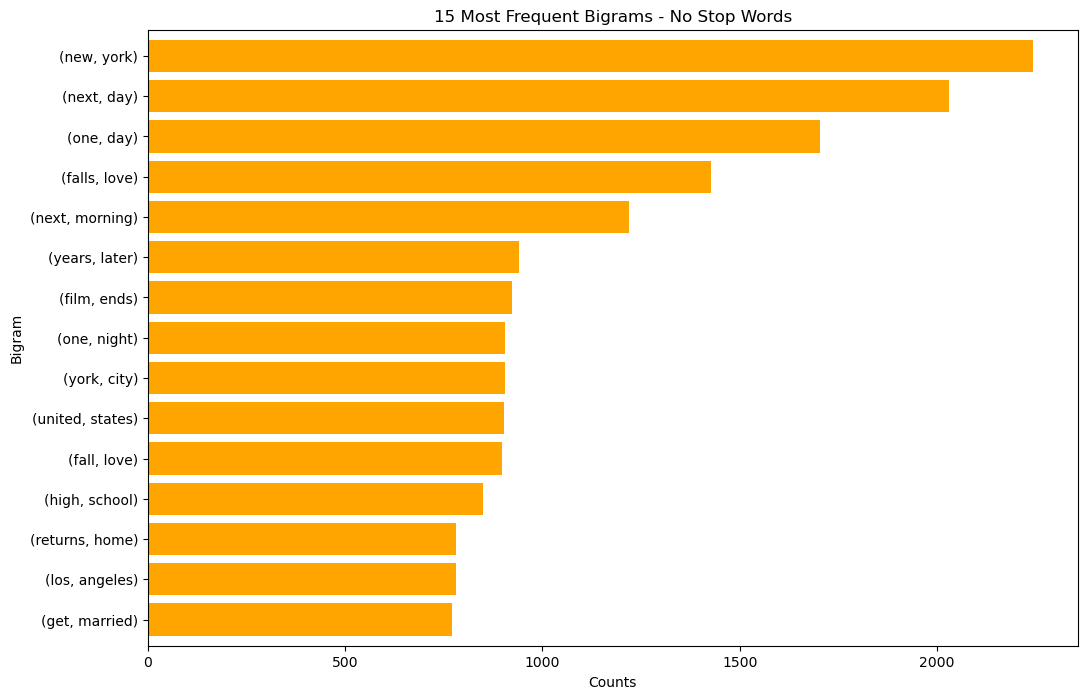

In [7]:
num = 15 # Number to display

# String of all words in every description
all_desc_words = ''

# Add all descriptions to all_desc_words
for desc in movies_data.description:
    all_desc_words += desc

# Split list of all descriptions into tokens
all_tokens = tokenizer.tokenize(all_desc_words)

# Get most frequent bigrams across all film descriptions
bigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens], 2)).value_counts())
bigrams[:num].sort_values().plot.barh(color='orange', width=0.8, figsize=(12, 8))
# Plot bigrams
plt.title(str(num) + " Most Frequent Bigrams")
plt.ylabel('Bigram')
plt.xlabel('Counts')
plt.show()

# Plot bigrams after removing stop words
bigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens if token.lower() not in stop_words], 2)).value_counts())
bigrams[:num].sort_values().plot.barh(color='orange', width=0.8, figsize=(12, 8))
plt.title(str(num) + " Most Frequent Bigrams - No Stop Words")
plt.ylabel('Bigram')
plt.xlabel('Counts')
plt.show()

Now I plot the most common trigrams. Again the first graph is dominated by stop words, while the second reveals common themes such as "world war ii", "new york city" and "based on a true story".

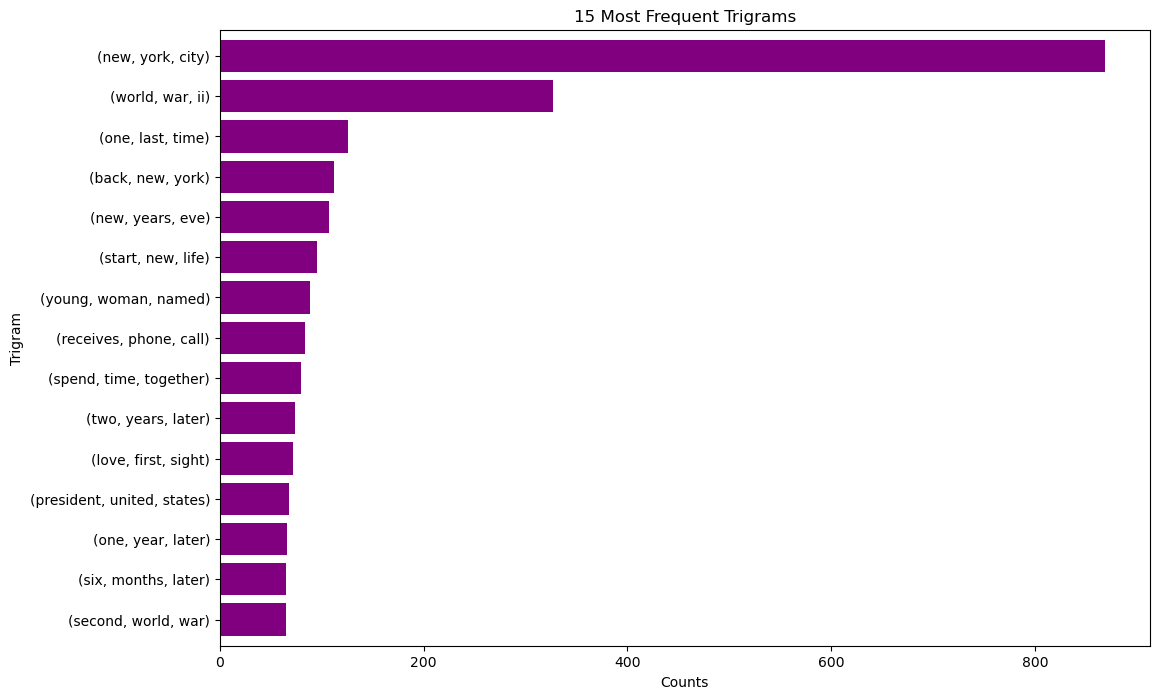

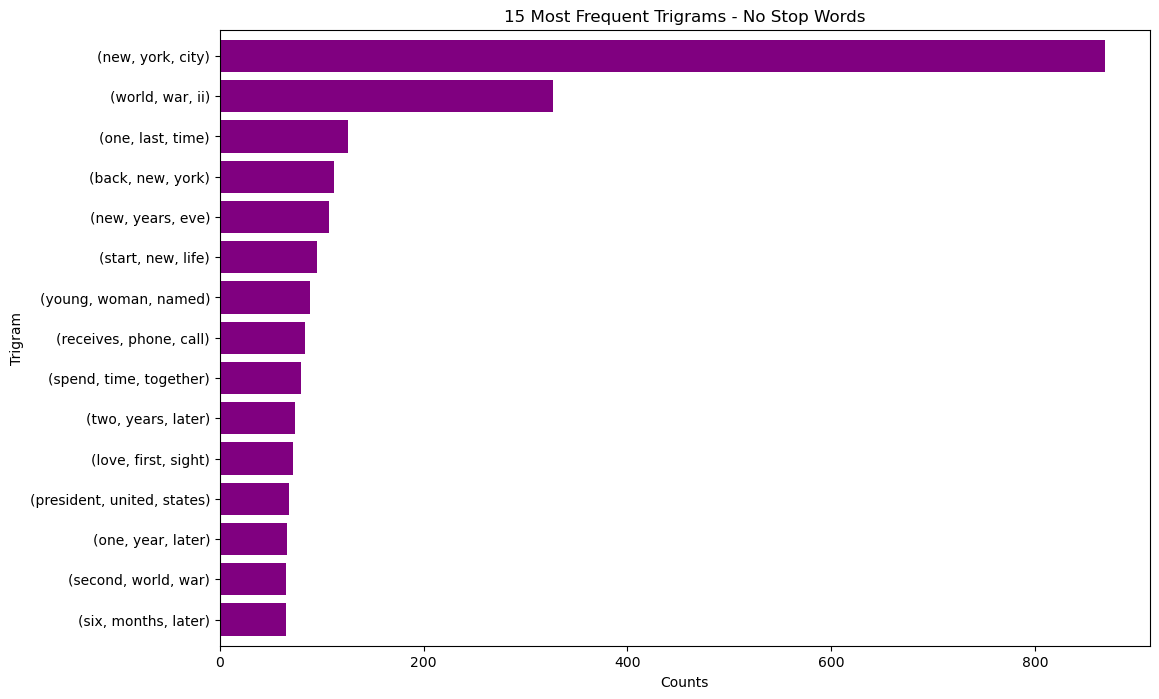

In [8]:
# Get most frequent trigrams across all film descriptions
trigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens], 3)).value_counts())
trigrams[:num].sort_values().plot.barh(color='purple', width=0.8, figsize=(12, 8))
# Plot trigrams
plt.title(str(num) + " Most Frequent Trigrams")
plt.ylabel('Trigram')
plt.xlabel('Counts')
plt.show()

# Plot trigrams after removing stop words
trigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens if token.lower() not in stop_words], 3)).value_counts())
trigrams[:num].sort_values().plot.barh(color='purple', width=0.8, figsize=(12, 8))
plt.title(str(num) + " Most Frequent Trigrams - No Stop Words")
plt.ylabel('Trigram')
plt.xlabel('Counts')
plt.show()

#### Label distribution

View the number of films belonging to each genre. Across all samples, the most common genres are Drama (26.7%), Comedy (16.4%) and Romance (8.0%). The least common is News with only one sample across the whole dataset. Other rare genres include Adult and Documentary which have two each, and Reality-TV which has three. After this is Film-Noir with 663. The rarest genres are removed later in the notebook as they do not provide enough samples to accurately train a classifier.

In [9]:
# Count the number of genres
genre_counts = np.zeros(len(unique_genres))

for genre_list in movies_data['genre'].apply(lambda genre_list: genre_list.split(", ")):
    for i in range(len(unique_genres)):
        if unique_genres[i] in genre_list:
            genre_counts[i] += 1

# Print counts for each genre
# for gen, con in zip(unique_genres, genre_counts):
#     print(str(gen) + ": " + str(int(con)))
            
# Plot the interactive pie chart
fig = go.Figure()
fig.add_trace(go.Pie(labels=unique_genres, values=genre_counts))
fig.show()

#### Visualising word relationships with displaCy

The graph below shows syntactic dependencies and part-of-speech tags. This gives a visual representation of the relationships between words in a description that should be captured by the LSTM.

In [10]:
film_desc = sample_movies.description.iloc[1]
sample_doc = nlp(film_desc)
print(colored("Entity recognition of the description:", color="blue", attrs=['bold']))
#displacy.render(sample_doc, style='ent', jupyter=True)
displacy.render(sample_doc, style='ent')

print(colored("\nDependency and POS tags:", color="blue", attrs=['bold']))
#displacy.render(sample_doc, style='dep', jupyter=True)
displacy.render(sample_doc, style='dep')

Entity recognition of the description:



Dependency and POS tags:


### Drop samples

As the dataset is large, samples are dropped so that the notebook can run in a reasonable time. `n_samples` specifies the maximum number of samples to use. Setting `n_samples = 0` will cause all suitable samples to be used, though the notebook will be slow to run.

`min_length` specifies the minimum number of words in a description and samples less than this will be removed.

Setting `remove_rare_genres = True` will remove genres with less than `rare_count` instances from the movies' labels. If a sample does not have a label for any remaining genre, it will be dropped. For example, if `rare_count = 10`, genres [News, Adult, Documentary, Reality-TV] are removed.

`max_genre_samples` is the maximum number of samples of each genre allowed. For example if `max_genre_samples = 100`, a maximum of 100 samples are allowed for Comedy, another 100 for Drama etc. This can be turned off by setting `max_genre_samples = 0`.

In [11]:
n_samples = 5000
min_length = 10
remove_rare_genres = True
rare_count = 200
max_genre_samples = 2000

# Create copy of movies_data
sampled_movies_data = movies_data

# Remove samples where description size is less than min_length
for i, desc in zip(sampled_movies_data.index, sampled_movies_data.description):
    if(len(tokenizer.tokenize(desc))) < min_length:
        sampled_movies_data = sampled_movies_data.drop(i)
        
if remove_rare_genres:
    # Find rare genres
    rare_genres = []
    
    for gen, count in zip(unique_genres, genre_counts):
        if count < rare_count:
            rare_genres.append(gen)
    print(colored("Genres removed: ", color="blue", attrs=['bold']) + str(rare_genres))
    
    for i, genre_list in zip(sampled_movies_data.index, sampled_movies_data['genre'].apply(lambda genre_list: genre_list.split(", "))):
        # Remove rare genres from list of film's genres
        new_genre_list = [gen for gen in genre_list if gen not in rare_genres]
        # Check if any genres remain
        if new_genre_list != []:
            # Update film's genre column
            sampled_movies_data.at[i,'genre'] = ", ".join(new_genre_list)
        else:
            # Else drop samples if all genres removed
            sampled_movies_data = sampled_movies_data.drop(i)

if max_genre_samples > 0:
    # Find the genres that have not been removed
    if remove_rare_genres:
        remaining_genres = list(set(unique_genres) - set(rare_genres))
    else:
        remaining_genres = unique_genres
        
    # Create an empty dataframe to record samples to keep
    updated_sampled_movies = pd.DataFrame()
    
    for gen in remaining_genres:
        # Find all samples belonging to the genre
        genre_samples = sampled_movies_data.loc[sampled_movies_data["genre"].str.contains(gen)]
        # Get the first n samples for that genre
        try:
            # Get the first n samples for that genre
            genre_samples = genre_samples.sample(n=max_genre_samples, random_state=1)
        except:
            # If n > number of samples of that genre, use them all
            None
        # Record the samples to keep
        updated_sampled_movies = pd.concat([updated_sampled_movies, genre_samples])
        
    # Remove any duplicates as some movies belong to multiple genres
    sampled_movies_data = updated_sampled_movies.drop_duplicates()
    # Shuffle order by sampling with the same size
    sampled_movies_data = sampled_movies_data.sample(len(sampled_movies_data), random_state=1)

print("1")
display(sampled_movies_data)
print("2")
display(remaining_genres)

if n_samples > 0:
    # Cap the number of samples to a maximum n_samples
    sampled_movies_data = sampled_movies_data.sample(n_samples, random_state=1)



# View selected samples
display(sampled_movies_data)

Genres removed: ['documentary', 'sports']
1


,title,genre,description
5042,5042,drama,described film publication betty palmer bennet...
10452,10452,"comedy, musical",ernie holley runs away wedding night thinks ki...
10430,10430,drama,set shelbyville tennessee 1978 film centers hi...
13950,13950,mystery,entry coulter irwin plays returning world war ...
5788,5788,animation,left world due loss natural resources winged h...
...,...,...,...
1645,1645,drama,marmaduke teenage great dane lives rural kansa...
17955,17955,romance,movie similar romeo juliet tragic love story t...
15704,15704,sci-fi,time death wife heather 16th century connor tr...
2737,2737,"drama, horror, thriller",ramesh ramesh arvind ganga soundarya married c...


2


['fantasy',
 'sci-fi',
 'animation',
 'action',
 'comedy',
 'thriller',
 'drama',
 'horror',
 'adventure',
 'crime',
 'romance',
 'mystery',
 'musical']

,title,genre,description
4035,4035,sci-fi,plot involves alien sterilox buttless galaxy s...
14537,14537,horror,young girl named akiko walks loses dog walking...
12335,12335,drama,unnatural accidental first nations woman named...
11732,11732,mystery,uncles newspaper larry elliot jack haley works...
502,502,thriller,group transported convicts suffering brutal tr...
...,...,...,...
17889,17889,animation,daffy introduced westerntype hero porky billed...
4972,4972,"drama, mystery",film deals problem mr roosevelt submitted whet...
7657,7657,romance,father adrien iván petrovich monk trappist mon...
18299,18299,musical,teen devian starts commentary ameen sayani cam...


### Samples

###### Stop words

Create a custom stop word list `movie_stop_words` of the most common words across all movie descriptions.

In [12]:
# Calculate frequency distribution to find most common words
movie_fd = FreqDist(token.lower() for token in all_tokens)

# Create custom stop word list
movie_stop_words = [word[0] for word in movie_fd.most_common(50)]
print(colored("Movie description stop words: ", color="blue", attrs=['bold']) + str(movie_stop_words)  + "\n")

Movie description stop words: ['one', 'back', 'tells', 'two', 'father', 'new', 'home', 'love', 'later', 'also', 'get', 'time', 'house', 'finds', 'police', 'man', 'life', 'find', 'family', 'however', 'goes', 'day', 'takes', 'go', 'mother', 'help', 'take', 'away', 'wife', 'tries', 'gets', 'night', 'first', 'money', 'son', 'friend', 'death', 'next', 'car', 'killed', 'film', 'becomes', 'young', 'friends', 'decides', 'leave', 'leaves', 'make', 'another', 'asks']



Select which stop word list to use and print it. Set `stop = 0` to use no pre-defined stop word list, `stop = 1` to use NLTK, or any other value, e.g. `stop = -1`, for spaCy. Set `add_custom_words = True` to add the `movie_stop_words` to the stop words.


Here I have used NLTK to filter out common words that do not contribute to the meaning of the descriptions. Although `movie_stop_words` could be appended, I decided against this as although words such as `love` and `young` are common in most genres, they may still help in distinguish some genres. For example, if comparing romance to horror.

In [13]:
stop = 1
add_custom_words = False

if stop == 0:
    # No stop words
    stop_words = []
elif stop == 1:
    # NLTK stop words
    stop_words = nltk.corpus.stopwords.words('english')
else:
    # spaCy stop words
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)

if add_custom_words:
    # Add custom stop words to list
    stop_words = list(set(stop_words + movie_stop_words))
    
if stop_words:
    # Print stop word list if not empty
    print(colored("Stop words: ", color="blue", attrs=['bold']) + str(stop_words)  + "\n")
    print(colored("Number of stop words: ", color="blue", attrs=['bold']) + str(len(stop_words)))

Stop words: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "s

###### Normalisation

Create a function to convert accented characters. For example, è becomes e in "Arsène Baudu and Hyacinthe, a pair of small-time crooks".

In [14]:
def remove_accents(text):
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

print(colored("Before: ", color="blue", attrs=['bold']) + "Arsène Baudu and Hyacinthe, a pair of small-time crooks")
print(colored("After: ", color="blue", attrs=['bold']) + str(remove_accents("Arsène Baudu and Hyacinthe, a pair of small-time crooks")))

Before: Arsène Baudu and Hyacinthe, a pair of small-time crooks
After: Arsene Baudu and Hyacinthe, a pair of small-time crooks


Load a model to produce contractions, e.g. can't becomes cannot in "They fall in love, but can't quite seem to get the timing right."

In [15]:


# Load pre-trained GloVe word embeddings
contraction = api.load("glove-twitter-25")

text = "They fall in love, but can't quite seem to get the timing right."

expanded_text = contractions.fix(text)

print(colored("Before: ", color="blue", attrs=['bold']) + text)
print(colored("After: ", color="blue", attrs=['bold']) + expanded_text)

Before: They fall in love, but can't quite seem to get the timing right.
After: They fall in love, but cannot quite seem to get the timing right.


###### Processing samples

Process film descriptions and store as `description_docs`
1. Normalisation by removing accents and contractions
2. Split descriptions into sentences and perform tokenisation
3. Remove puncuation
4. Remove stop words (optional)
5. Correct spelling (optional)
5. Apply lemmatizing or stemming (optional)

---

I decided to use lemmatization rather than stemming as tokens are embedded with GloVe pre-trained before they are inputting into the LSTM. As GloVe was trained on full English words, lemmatization is more suitable as it keeps words in dictionary form using PoS tagging. By contrast, stemming reduces words to their stem, e.g. "ponies" -> "poni" which are less likely to be included in the pre-trained embeddings.

Here I have converted text into 1-grams, although common n-grams found in GloVe such as "new-york" could be added as this would help the LSTM to pick up on word depencencies.

Even though I added pyspellchecker to correct spelling mistakes, I did not use it because it massively increases processing time.

In [16]:
def process_text_samples(data, stop_list=[], contractions=False, spell_correct=False, lemmatize=False, stem=False, stemmer_algorithm="porter"):
    # List of all samples
    samples = []
    
    # Create spell checker
    spell_check = SpellChecker()
    
    for sample in data:
        # Change accented characters, e.g à -> a
        sample = remove_accents(sample)
        # Contract words, e.g "hasn't" -> "has not"
        if contractions:
            sample = list(contraction.expand_texts([sample], precise=True))
            sample = ''.join(contracted)
        # Input sample text into spaCy language processor
        doc = nlp(sample)
        # Split sample text into sentences
        sentences = list(doc.sents)
        for sent_idx in range(len(sentences)):
            # Remove punctuation tokens, e.g. ! , .
            sentences[sent_idx] = [token for token in sentences[sent_idx] if not token.is_punct]
            
            # Remove stop words
            if stop_list:
                sentences[sent_idx] = [token for token in sentences[sent_idx] if token.text.lower() not in stop_list]
                
            # Correct spelling mistakes, e.g. "athiest" -> "atheist"
            if spell_correct:
                sentences[sent_idx] = [nlp(spell_check.correction(token.text))[0] for token in sentences[sent_idx]]
            
            # Apply lemmatization
            if lemmatize:
                # Resolve words to their dictionary form using PoS tags
                sentences[sent_idx] = [token.lemma_.lower() for token in sentences[sent_idx]]
                
            # Apply stemming (only if lemmatization not applied)
            elif stem:
                # Set stemmer type
                if stemmer_algorithm[0].lower() == "s":
                    # Snowball stemmer is advancement on Porter
                    stemmer = SnowballStemmer(language='english')
                else:
                    # Default to Porter stemmer if not specified
                    stemmer = PorterStemmer()
                # Stem tokens
                for word_idx in range(len(sentences[sent_idx])):
                    # Apply stemmer to each word
                    stemmed = stemmer.stem(sentences[sent_idx][word_idx].text)
                    # Convert back to type Token and update word in sentence
                    sentences[sent_idx][word_idx] = nlp(stemmed)[0]
                    
            # Remove remaining punctuation within tokens, e.g. "(years)" -> "years", not including -
            sentences[sent_idx] = [token.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')) for token in sentences[sent_idx]]
            
        # Split words containing dash or spaces caused by lemmatization, e.g. "16-year" -> "16" + "year"
        for k in range(len(sentences)):
            new_sentence = []
            for token in sentences[k]:
                split_token = re.split(' |-', token)
                for word in split_token:
                    # Check word not empty
                    if word:
                        new_sentence.append(word)
            # Replace words in sentence
            sentences[k] = new_sentence
                    
        # Remove empty lists from list of sentences
        sentences = [sent for sent in sentences if sent != []]
        samples.append(sentences)
        
    return samples

# List of description 'documents' seperated into sentences
description_docs = process_text_samples(data=sampled_movies_data.description,
                                        spell_correct=False, 
                                        stop_list=stop_words,
                                        lemmatize=True)

# View extract
print(colored("First 5 descriptions:", color="blue", attrs=['bold']))
for i in range(5):
    print(colored(str(i), color="blue", attrs=['bold']) + " " + str(description_docs[i]))

First 5 descriptions:
0 [['plot', 'involve', 'alien', 'sterilox', 'buttless', 'galaxy', 'send', 'earth', 'order', 'find', 'perfect', 'woman', 'use', 'create', 'race', 'servant', 'sterilox', 'teleport', 'lab', 'mad', 'scientist', 'name', 'dr', 'breedlove', 'offer', 'sterilox', 'number', 'beautiful', 'woman', 'choose', 'highlight', 'movie', 'involve', 'dance', 'number'], ['three', 'breedlove', 'woman', 'gyrate', 'rock', 'music']]
1 [['young', 'girl', 'name', 'akiko', 'walk', 'lose', 'dog', 'walk', 'along', 'beach', 'follow'], ['dog', 'european', 'mansion', 'old', 'man', 'stares', 'chase', 'dog', 'inside', 'akiko', 'find', 'front', 'dead', 'woman', 'piano', 'meet', 'vampire', 'mori', 'kishida', '18', 'year', 'later', 'akiko', 'midori', 'fujita', 'live', 'near', 'lake', 'still', 'haunt', 'happen', 'believe', 'dream', 'akiko', 'friend', 'boat', 'operator', 'kusaku', 'receive', 'strange', 'package', 'turn', 'white', 'coffin', 'kusaku', 'complain', 'ship', 'agent', 'return', 'find', 'coffin',

Again I have a filter to remove samples if they contain less words than `min_words`. This is because removing stop words in the code above will sometimes make some descriptions too short which makes them unsuitable for model training.

In [17]:
min_words = 5

# Convert docs in description_docs from list of sentences to list of words
word_docs = []

for doc in description_docs:
    # Make a list of all words
    words = [word for sent in doc for word in sent]
    word_docs.append(words)

# Count number of words in each processed description
desc_lengths = [len(desc) for desc in word_docs]

# Add processed description to dataframe
sampled_movies_data['processed_description'] = word_docs
# Remove descriptions with less than n words
sampled_movies_data['length'] = desc_lengths
sampled_movies_data = sampled_movies_data[sampled_movies_data.length >= min_words]
sampled_movies_data = sampled_movies_data.drop(columns=['length'])
sampled_movies_data

,title,genre,description,processed_description
4035,4035,sci-fi,plot involves alien sterilox buttless galaxy s...,"[plot, involve, alien, sterilox, buttless, gal..."
14537,14537,horror,young girl named akiko walks loses dog walking...,"[young, girl, name, akiko, walk, lose, dog, wa..."
12335,12335,drama,unnatural accidental first nations woman named...,"[unnatural, accidental, first, nations, woman,..."
11732,11732,mystery,uncles newspaper larry elliot jack haley works...,"[uncles, newspaper, larry, elliot, jack, haley..."
502,502,thriller,group transported convicts suffering brutal tr...,"[group, transport, convict, suffer, brutal, tr..."
...,...,...,...,...
17889,17889,animation,daffy introduced westerntype hero porky billed...,"[daffy, introduce, westerntype, hero, porky, b..."
4972,4972,"drama, mystery",film deals problem mr roosevelt submitted whet...,"[film, deal, problem, mr, roosevelt, submit, w..."
7657,7657,romance,father adrien iván petrovich monk trappist mon...,"[father, adrien, ivan, petrovich, monk, trappi..."
18299,18299,musical,teen devian starts commentary ameen sayani cam...,"[teen, devian, start, commentary, ameen, sayan..."


### Labels

Encode the labels (genres) of each film as a binary multi-hot representation using `binary_encoder`. This allows comparision between the LSTM's output probabilities against each label. The binary encoder is saved to the file specified by `binary_encoder_file` so that it may be reloaded again.

In [18]:
binary_encoder_file = 'binary_encoder.pickle'

# Recalculate unique genres after removing samples
sampled_unique_genres, sampled_all_genres = find_unique_genres(sampled_movies_data)

# Create a binary encoder
binary_encoder = MultiLabelBinarizer(classes=sampled_unique_genres)
# New dataframe to store encoding of each film
binary_genres = pd.DataFrame(columns=sampled_unique_genres)

for genre_list in sampled_movies_data['genre'].apply(lambda genre_list: genre_list.split(", ")):
    # Create encoding for each film
    film_binary = binary_encoder.fit_transform([genre_list])
    # Add genre encoding as a row to the dataframe
    binary_genres.loc[len(binary_genres)] = film_binary[0]
    
pickle.dump(binary_encoder, open(binary_encoder_file, 'wb'))
print("Saved label binary encoder to \"" + colored(str(binary_encoder_file), color="magenta", attrs=['bold']) + "\"\n")
    
# Change so that row indexes match film indexes
binary_genres.index = sampled_movies_data.index
print(colored("Multi-Hot Binary Genres: ", color="blue", attrs=['bold']))
binary_genres

4035             sci-fi
14537            horror
12335             drama
11732           mystery
502            thriller
              ...      
17889         animation
4972     drama, mystery
7657            romance
18299           musical
6250           thriller
Name: genre, Length: 5000, dtype: object
['action', 'adventure', 'animation', 'comedy', 'crime', 'drama', 'fantasy', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller']
Saved label binary encoder to "binary_encoder.pickle"

Multi-Hot Binary Genres: 


,action,adventure,animation,comedy,crime,drama,fantasy,horror,musical,mystery,romance,sci-fi,thriller
4035,0,0,0,0,0,0,0,0,0,0,0,1,0
14537,0,0,0,0,0,0,0,1,0,0,0,0,0
12335,0,0,0,0,0,1,0,0,0,0,0,0,0
11732,0,0,0,0,0,0,0,0,0,1,0,0,0
502,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17889,0,0,1,0,0,0,0,0,0,0,0,0,0
4972,0,0,0,0,0,1,0,0,0,1,0,0,0
7657,0,0,0,0,0,0,0,0,0,0,1,0,0
18299,0,0,0,0,0,0,0,0,1,0,0,0,0


View the distribution of labels for selected samples:
* As 2821 samples have the genre Drama, this means that 56% of the samples belong to this label.
* The least common genre is now Horror with 12%. However, 607 samples is still a sufficient number to train the classifier.

Note the counts do not add to the number of samples as genres are multi-label.

In [19]:
# Count the number of genres
sampled_genre_counts = np.zeros(len(sampled_unique_genres))

for genre_list in sampled_movies_data['genre'].apply(lambda genre_list: genre_list.split(", ")):
    for i in range(len(sampled_unique_genres)):
        if sampled_unique_genres[i] in genre_list:
            sampled_genre_counts[i] += 1

# Print counts for each genre
for gen, con in zip(sampled_unique_genres, sampled_genre_counts):
    print(str(gen) + ": " + str(int(con)))
            
# Plot the interactive pie chart
fig = go.Figure()
fig.add_trace(go.Pie(labels=sampled_unique_genres, values=sampled_genre_counts))
fig.show()

action: 732
adventure: 231
animation: 231
comedy: 1084
crime: 305
drama: 1182
fantasy: 139
horror: 494
musical: 250
mystery: 159
romance: 546
sci-fi: 285
thriller: 506


The classes are imbalanced which can be a problem as it means the classifier can overpredict dominant classes, such as Drama, and under predict minority ones such as Horror. However, a weighted value for each label can be used to scale loss calculation so that the model is penalized more if it misclassifies a minority genre. Here this is calculated as the number of label counts without a genre divided by the total number of label counts.

In [20]:
label_weights = torch.zeros(len(sampled_genre_counts))
total_labels = sum(sampled_genre_counts)

for i in range(len(sampled_genre_counts)):
    # Number of true negative counts / total
    label_weights[i] = (total_labels - sampled_genre_counts[i]) / total_labels

label_weights

tensor([0.8809, 0.9624, 0.9624, 0.8236, 0.9504, 0.8076, 0.9774, 0.9196, 0.9593,
        0.9741, 0.9111, 0.9536, 0.9176])

###### Create new dataframe of processed samples

This dataframe below contains the fields used further into the notebook to construct a TorchText Dataset.

In [21]:
sample_ids = []
sample_descriptions = []
sample_labels = []

# Iterate through each film finding the index, label and description
for idx, values, desc in zip(binary_genres.index, binary_genres.values, word_docs):
    sample_ids.append(idx)
    sample_descriptions.append(' '.join(desc))
    sample_labels.append(values)
            
# Convert to dataframe
processed_samples = pd.DataFrame({"ID": sample_ids, "Description" : sample_descriptions, "Label" : sample_labels})
processed_samples

,ID,Description,Label
0,4035,plot involve alien sterilox buttless galaxy se...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,14537,young girl name akiko walk lose dog walk along...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,12335,unnatural accidental first nations woman name ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,11732,uncles newspaper larry elliot jack haley work ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,502,group transport convict suffer brutal treatmen...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...
4995,17889,daffy introduce westerntype hero porky bill co...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4996,4972,film deal problem mr roosevelt submit whether ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
4997,7657,father adrien ivan petrovich monk trappist mon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4998,18299,teen devian start commentary ameen sayani came...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


# Supervised Classification

Set up PyTorch to make the results semi-reproducable.

In [22]:
# Seed torch results semi-reproducable
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Set device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Classifier class

Define a class for the LSTM classifier.

In [23]:
class FilmClassifierLSTM(nn.Module):
    """ 
    Long-short term memory (LSTM) classifier
    Layers: Embedding -> LSTM -> fully connected
    
    Parameters:
        n_vocab: Number of words TEXT Field was trained on
        n_classes: Number of genres
        pad_index: Index of <pad> token
        unk_index: Index of <unk> token
        n_embedding: Size of the trained vectors, e.g if using 'glove.6B.100d', set to 100
        pretrained_embeddings: Vectors from pre-trained word embedding such as GloVe
        n_hidden: Number of hidden layers
        dropout: Dropout rate, e.g 0.2 = 20% dropout
        activation: Set as "softmax" or "sigmoid"
        bidirectional: Whether to use bidirectional LSTM
        batch_norm: Whether to apply a batch normalization layer
    
    Return on forward pass:
        output: Predicted probabilities for each class
        
    """
    
    def __init__(self, n_vocab, n_classes, pad_index, unk_index, n_embedding, pretrained_embeddings=None,
                 n_hidden=256, dropout=0.2, activation="sigmoid", bidirectional=True, batch_norm=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        
        if bidirectional:
            # Use two layers for bidirectionality
            n_layers = 2
            # Double size of linear output
            linear_hidden = n_hidden * 2
        else:
            n_layers = 1
            linear_hidden = n_hidden
        
        # Create model layers
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(n_vocab, n_embedding, padding_idx=pad_index) # Tell embedding not to learn <pad> embeddings
        self.lstm = nn.LSTM(n_embedding, n_hidden, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.batchnorm = nn.BatchNorm1d(linear_hidden)
        self.linear = nn.Linear(linear_hidden, n_classes)
        
        # Set output activation function
        if activation == "softmax":
            self.activation = nn.Softmax(dim=1)
        else:
            # Sigmoid recommended for multi-label
            self.activation = nn.Sigmoid()
        
        if pretrained_embeddings != None:
            # Replace weights of embedding layer
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Set padding and unknown tokens to zero
            self.embedding.weight.data[pad_index] = torch.zeros(n_embedding)
            self.embedding.weight.data[unk_index] = torch.zeros(n_embedding)

    def forward(self, text, text_lengths):
        # Create word embedding, then apply drop out
        embedded = self.embedding(text)
        dropped_embedded = self.dropout(embedded)
        # Pack the embedding so that LSTM only processes non-embedded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(dropped_embedded, text_lengths.to('cpu'))
        # Return output of all hidden states in the sequence, hidden state of the last LSTM unit and cell state
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack packed_output
        unpacked_output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        if self.bidirectional:
            # Find the final two hidden states and join them together
            top_two_hidden = torch.cat((hidden[-1], hidden[-2]), dim=1)
            if self.batch_norm:
                # Add aa batch normalization layer
                top_two_hidden = self.batchnorm(top_two_hidden)
            # Apply dropout, pass through fully connected layer, then apply activation function
            output = self.activation(self.linear(self.dropout(top_two_hidden)))
        else:
            # Apply dropout to final hidden state, pass through fully connected layer, then apply activation function
            output = self.activation(self.linear(self.dropout(hidden[-1])))

        return output

### Set up training, testing and validation data

Create TorchText Fields defining the ID, description and multi-hot label of each film. These correspond to the columns in `processed_samples`. Then construct a TorchText dataset from the films in `processed_samples`. 

In [24]:
TEXT_field_file = "TEXT.Field"

# Create fields
RAW = data.RawField()
TEXT = data.Field(tokenize="spacy", include_lengths=True) # Use packed padded sequences so only non-padded elements are processed

LABEL = data.LabelField(dtype=torch.float, use_vocab=False, sequential=False, is_target=True, unk_token=None)

# Map rows in processed_samples to the matching fields
fields = [('id', RAW), ('text', TEXT), ('label', LABEL)]
examples = [data.Example.fromlist(row, fields) for row in zip(processed_samples['ID'].to_list(),
                                                              processed_samples['Description'].to_list(), 
                                                              processed_samples['Label'].to_list())]
# Remove any film descriptions with less than two words
clean_examples = []
for i in range(len(examples)):
    if not len(examples[i].text) < 2:
        clean_examples.append(examples[i])
        
# Construct a torchtext dataset
dataset = data.Dataset(clean_examples, fields)

# Save the TEXT field to file
dill.dump(TEXT, open(TEXT_field_file, "wb"))

###### Split data

Separate dataset samples into training, testing and validation in a ratio 0.49 : 0.3 : 0.21. This means that 70% of the data is used during model training, while 30% is kept unseen for evaluation.

To use k-fold cross-validation with k folds, set `use_k_folds = True`. For example, if `k = 5`, training data will be split 5 different ways. If k-folds is not used, data will be randomly split. I used cross validation when training the final model, but not when making small changes during model development. This is because it takes a long time to run as it trains k different models.

In [25]:
use_k_folds = True
k = 5

# Store each k-fold split
train_folds = []
val_folds = []

if use_k_folds:
    for i in range(k):
        # Split data into 70% train : 30% test
        train_data, test_data = dataset.split(split_ratio=0.7, random_state = random.seed(0))
        # Split train dataset 70% train : 30% validation
        train_data, val_data = train_data.split(split_ratio=0.7, random_state = random.seed(i))
        # Add folds to lists
        train_folds.append(train_data)
        val_folds.append(val_data)
else:
    # Split data into 70% train : 30% test
    train_data, test_data = dataset.split(split_ratio=0.7, random_state = random.seed(0))
    # Split train dataset 70% train : 30% validation
    train_data, val_data = dataset.split(split_ratio=0.7, random_state = random.seed(0))
    # K-fold cross validation not used so train_folds and val_folds have one element each
    train_folds.append(train_data)
    val_folds.append(val_data)
    
print(colored("Samples in train data: ", color="blue", attrs=['bold']) + str(len(train_data)))
print(colored("Samples in test data: ", color="blue", attrs=['bold']) + str(len(test_data)))
print(colored("Samples in validation data: ", color="blue", attrs=['bold']) + str(len(val_data)))

Samples in train data: 2450
Samples in test data: 1500
Samples in validation data: 1050


In [26]:
# Print sample in validation data
# vars(val_data[0])

###### Set word embeddings of tokens

Construct a vocabulary for the TEXT (description) field. `trained_vector` is set as a pre-trained word embedding vector, such as:
* `"glove.6B.100d"` - 100 dimensional vectors trained on Wikipedia 2014 and Gigaword 5 using the GloVe algorithm
* `"charngram.100d"` - 100 dimensional vectors created from the average of unique character n-gram embeddings
* `"fasttext.simple.300d"` - 300 dimensional vectors trained on Wikinews

---

For this project I decided to use GloVe. This is because:
1. Tokens have not been processed in the correct format to use CharNGram, e.g. ['2gram-ok', '3gram-#BEGIN#na', '4gram-ess#END#'].
2. Although simple FastText is also suitable, fewer words from the dataset are in the pre-trained embedding (see section below). This is perhaps because GloVe was trained on Wikipedia articles, some of which are about films. By contrast, FastText was trained on news articles, which are less likely to be about niche films.

In [27]:
trained_vector = "glove.6B.100d"
max_vocab = 30000

# Build text using pre-trained vectors
TEXT.build_vocab(word_docs, max_size=max_vocab, vectors=trained_vector, unk_init=torch.Tensor.normal_)

print(colored("Unique tokens in TEXT vocabulary: ", color="blue", attrs=['bold']) + str(len(TEXT.vocab)) + "\n")
print(colored("Extract of TEXT vocab: ", color="blue", attrs=['bold']) + str(TEXT.vocab.itos[:100]) + "\n")
print(colored("Most common tokens: ", color="blue", attrs=['bold']) + str(TEXT.vocab.freqs.most_common(20)))

Unique tokens in TEXT vocabulary: 30002

Extract of TEXT vocab: ['<unk>', '<pad>', 'find', 'take', 'kill', 'go', 'get', 'tell', 'leave', 'one', 'man', 'see', 'back', 'make', 'try', 'love', 'father', 'return', 'two', 'friend', 'come', 'become', 'give', 'meet', 'police', 'time', 'home', 'day', 'later', 'help', 'new', 'life', 'reveal', 'use', 'also', 'house', 'call', 'arrive', 'however', 'family', 'fall', 'end', 'begin', 'decide', 'name', 'ask', 'know', 'mother', 'escape', 'show', 'night', 'death', 'attempt', 'film', 'work', 'car', 'wife', 'young', 'away', 'discover', 'run', 'turn', 'woman', 'want', 'girl', 'say', 'year', 'son', 'attack', 'next', 'live', 'die', 'way', 'plan', 'first', 'fight', 'murder', 'start', 'daughter', 'lead', 'another', 'money', 'force', 'shoot', 'not', 'follow', 'learn', 'send', 'order', 'believe', 'realize', 'marry', 'story', 'meanwhile', 'brother', 'head', 'child', 'old', 'room', 'group']

Most common tokens: [('find', 6345), ('take', 5727), ('kill', 5670), ('go'

In [28]:
# View tokens in CharNGram
# vectors = torchtext.vocab.CharNGram()
# vectors.itos

###### View untrained tokens

View all tokens that have not been given a pre-trained vector word embedding, i.e. the embeddings the model will have to learn from scratch. When using `"glove.6B.100d"` there are fewer words not included compare to using `"fasttext.simple.300d"`. It is better if this number is lower as this means the embedding is better suited to the data. Therefore, GloVe has been selected.

Looking at these tokens is also useful for seeing how I could improve token pre-processing so that more of them were included. For example during development, I noticed that tokens such as "(years" were displayed here as spaCy `token.is_punct` did not remove the punctuation within tokens. After stripping this punctuation, more words were mapped to a pre-trained embedding and the model's accuracy improved.

Another observation is that many of these words contain spelling mistakes, such as "neiborhood", "charachter" and "athiest". Therefore I added a spell corrector to the pre-processing. However, I have not used it here as spell correction is computationally expensive.

In [29]:
if trained_vector in ["glove.6B.100d", "charngram.100d", "fasttext.simple.300d"]:
    if trained_vector == "glove.6B.100d":
        vectors = torchtext.vocab.GloVe(name='6B', dim=100)
    elif trained_vector == "charngram.100d":
        vectors = torchtext.vocab.CharNGram()
    else:
        vectors = torchtext.vocab.FastText(language="simple")
    # Find all unique words in film descriptions
    sampled_film_words = list(set([word for doc in word_docs for word in doc]))
    # Find words not in vector word embedding
    vector_words = vectors.itos
    untrained_words = [word for word in sampled_film_words if word not in vector_words]
    
    print(colored(str(len(untrained_words)) + " words not in vector embedding: ", color="green", attrs=['bold']) + str(untrained_words) + "\n")

16392 words not in vector embedding: ['demolitionist', 'akashs', 'miuras', 'munceford', 'deboras', 'daveyfitzpatrick', 'mariphasas', 'headoverheel', 'atat', 'safetyshe', 'manoharlal', 'nearpristine', 'daytoday', 'birle', 'selfhelp', 'peytrauds', 'smeldey', 'mushran', 'jackpine', 'tumpa', 'stormlike', 'salarymans', 'almostcomplete', 'shaguns', 'jondor', 'bholas', 'aones', 'byzanium', 'gonzola', 'cricketerturnedunderworld', 'helicopterdelivered', 'bridevictim', 'sintai', 'thurmans', 'rearprojection', 'nonlinearly', 'khurrana', 'emmas', 'wordf', 'mattys', 'whileflorence', 'osmans', 'dhartipur', 'injurie', 'angelna', 'insidethepark', 'williamswho', 'asquad', 'iceworking', 'otachis', 'mildmannered', 'unexpectedlooke', 'shatterdome', 'dutts', 'parajuku', 'takatoshis', 'enrapture', 'norahs', 'celebrum', 'jillians', 'beeku', 'marykate', 'nowcommissar', 'necrotize', 'gagoola', 'takararu', 'shakuntalas', 'khizir', 'clarifie', 'palinov', 'erby', 'wexel', 'motherinlaw', 'bouldeston', 'padam10', 's

### Create a new classifier

Set the model parameters:
* `drop_out`: Set the dropout rate, where 0.5 is 50%. This is a method to reduce overfitting.
* `activation`: The activation function can be set as `"sigmoid"` or `"softmax"`. Even though the softmax activation function can be used, I decided that sigmoid was more appropriate. This is because this is a multi-label classification problem and so it makes sense that each genre is given a predicted probability between 0.0 - 1.0. Also, as there are a large number of classes (genres) the results from softmax are small as they add to 1.0.
* `bidirectional`: Setting as `True` will use a bidirectional LSTM. This allows the model to analyse the sentences from start to end and from end to start.
* `batch_size`: The number of samples to be used in each mini-batch.
* `label_threshold`: The minimum value returned by the activation function for a particular label to be included in the prediction. For example if `label_threshold = 0.5` and sigmoid returns [0.2, 0.7, 0.4], this will be converted to binary labels [0, 1, 0]. While if `label_threshold = 0.3`, the prediction will become [0, 1, 1]. Therefore lowering this value can increase the number of predicted genres.
* `n_lstm_layers`: Number of LSTM hidden layers.
* `use_weighted_loss`: Whether to use a weighted loss function. The purpose of this is to give a larger penalty whenever the model incorrectly identifies genres with less samples.
* `batch_norm`: Whether to add a batch normalization layer to the model.

In [30]:
dropout_rate = 0.7
activation = "sigmoid"
bidirectional = True
batch_size = 32
label_threshold = 0.5
n_lstm_layers = 120
use_weighted_loss = False
batch_norm = True

# Get vocab size of trained text field
vocab_size = len(TEXT.vocab)

# Padding and unknow indexes allow these tokens to be ignored
padding_index = TEXT.vocab.stoi[TEXT.pad_token]
unknown_index = TEXT.vocab.stoi[TEXT.unk_token]
# Embedding size must be the same as pre-trained vectors
embedded_dim = int(trained_vector[len(trained_vector)-4:len(trained_vector)-1])
# Get the pre-trained embedding
pretrained_vectors = TEXT.vocab.vectors

### Train the classifier

The function below returns a tensor of weights that can be used to created a weighted loss function. Applying these weights will make the loss function assign a high penalty if it does not predict an expected label, and a lowered penalty otherwise. This was created because the model was converging to predict all zeros as a way to minimise loss. When this happens, this meant that it was not learning to predict any genre for the majority of descriptions.

These weights are calculated if `weighted_loss = True` when calling the training function `train_model`. Optionally, `class_weights` can be added as a scaling factor so that the loss function is weighted towards giving a higher loss for incorrectly predicted rarer genres.

In [31]:
def create_weights(labels, prediction, predicted_labels, threshold, class_weights=None):
    
    """ Create customised weights for the loss function """
    
    weights = torch.ones(len(prediction), len(prediction[0])).to(device)
    
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            # Find all labels that should be predicted
            if labels[i][j] == 1:
                # Check if label is predicted
                if prediction[i][j] < threshold:
                    # Assign a higher penalty if not predicted
                    weights[i][j] = 1.2
                else:
                    # Lower penalty if predicted label is correct
                    weights[i][j] = 0.5
            # Check if predicted all zeros
            if torch.count_nonzero(predicted_labels[i]) == 0:
                # Increase pentalty if no predictions made
                weights[i] = weights[i] * 1.2
                
    # Add label weighting if given
    if class_weights != None:
        class_weights = class_weights.to(device) * 1.2
        for k in range(len(weights)):
            weights[k] = weights[k] * class_weights
                
    return weights

Below is the function used to train the model. The best model is saved if a file name is given, e.g. `file = 'film_classifier.pt'`. The best model is determined by `measure`, which can be set to either loss or accuracy. For example, if `measure = "accuracy"`, the weights of the model with the highest validation accuracy will be saved.

Intitally, I used cross entropy to evaluate predicted labels. However, this only let me evaluate performance against one matching label, e.g. `drama`, even though some films have up to three genres, e.g. `drama, comedy, sci-fi`. This meant that it was treating the problem as multi-class instead of multi-label, and so the model was sometimes being penalised even though its prediction was correct. To solve this, the labels are now converted into multi-hot binary encoding so that the multi-label representation would be captured. The loss function was therefore changed to binary cross entropy.

In [32]:
def train_model(model, train_data, val_data, optim, epochs=5, prediction_threshold=0.5,
                weighted_loss=False, class_weights=None, measure="accuracy", calculate_f1=False, print_progress=True,
                print_step=5, best_file=None, final_file=None):
    
    """ 
    Train the model and save best state
    
    Parameters:
        train_data: iterator of train batches
        val_data: iterator of validation batches
        optim: the optimiser
        epochs: number of epochs
        prediction_threshold: the number that must be exceedd to predict a binary label
        weighted_loss: use weighted version of loss function
        class_weights: a scaling factor for the weighting of each label, only used if weighted_loss=True
        measure: save the model with the best validation "accuracy" or "loss"
        calculate_f1: whether to calculate F1 score
        print_progress: print epoch loss
        print_step: step for print_progress, i.e. print_step=5 prints loss every 5 epochs
        best_file: save state of the model that achieves the best accuracy / loss (set by measure) to this file if specified, e.g. 'best_model.pt'
        final_file: save the final state of the model
        
    Return:
        metrics: a dictionary of metrics for training performance, e.g. 'train_loss'
    
    """
    
    # Record metrics loss, f1 and accuracy
    train_loss_over_epochs, val_loss_over_epochs = [], []
    train_f1_over_epochs, val_f1_over_epochs = [], []
    train_accuracy_over_epochs, val_accuracy_over_epochs = [], []
    
    # Record the best validation loss or accuracy
    if measure == "loss":
        best_score = float('inf')
    else:
        best_score = float(-1)
    
    for epoch in range(epochs):
        # Record epoch metrics
        train_epoch_loss, val_epoch_loss = 0, 0
        train_epoch_f1, val_epoch_f1 = 0, 0
        train_epoch_accuracy, val_epoch_accuracy = 0, 0
        
        # Train the classifier
        model.train()
        batch_count = 0
        
        for batch in train_data:
            batch_count += 1
            # Clear gradients of optimizer
            optim.zero_grad()
            # Make prediction and get actual labels
            text, text_lengths = batch.text
            prediction = model(text, text_lengths)
            true_labels = batch.label
            
            # Convert probabilities to binary labels, e.g. [0.6, 0.1] -> [1, 0]
            predicted_labels = torch.tensor([[1 if value > prediction_threshold else 0 for value in sample] for sample in prediction])
                
            if weighted_loss:
                # Create tensor of weighted values
                weights = create_weights(true_labels, prediction, predicted_labels, prediction_threshold, class_weights=class_weights)
            else:
                # Create tensor of 1s, i.e. weights are all the same
                weights = torch.ones(len(prediction), len(prediction[0])).to(device)
            
            # Calculate and record loss
            loss = F.binary_cross_entropy(prediction, true_labels, weight=weights)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
            
            # Calculate and record f1 score and accuracy
            if calculate_f1:
                f1 = f1_score(predicted_labels, true_labels.cpu(), average='micro', zero_division=1)
                train_epoch_f1 += f1
            accuracy = accuracy_score(predicted_labels, true_labels.cpu())
            train_epoch_accuracy += accuracy
            
        # Record epoch's average training loss, f1 and accuracy
        train_loss_over_epochs.append(train_epoch_loss/batch_count)
        if calculate_f1:
            train_f1_over_epochs.append(train_epoch_f1/batch_count)
        train_accuracy_over_epochs.append(train_epoch_accuracy/batch_count)
        
        # Evaluate on validation data
        model.eval()
        batch_count = 0
        
        with torch.no_grad():
            for batch in val_data:
                batch_count += 1
                text, text_lengths = batch.text
                prediction = model(text, text_lengths)
                true_labels = batch.label
                
                predicted_labels = torch.tensor([[1 if value > prediction_threshold else 0 for value in sample] for sample in prediction])
                
                if weighted_loss:
                    weights = create_weights(true_labels, prediction, predicted_labels, prediction_threshold, class_weights=class_weights)
                else:
                    weights = torch.ones(len(prediction), len(prediction[0])).to(device)
                
                loss = F.binary_cross_entropy(prediction, true_labels, weight=weights)
                val_epoch_loss += loss.item()
                
                # Calculate and record f1 score and accuracy
                if calculate_f1:
                    f1 = f1_score(predicted_labels, true_labels.cpu(), average='micro', zero_division=1)
                    val_epoch_f1 += f1
                accuracy = accuracy_score(predicted_labels, true_labels.cpu())
                val_epoch_accuracy += accuracy
                
        # Record epoch's average training loss, f1 and accuracy
        val_loss_over_epochs.append(val_epoch_loss/batch_count)
        if calculate_f1:
            val_f1_over_epochs.append(val_epoch_f1/batch_count)
        val_accuracy_over_epochs.append(val_epoch_accuracy/batch_count)
        
        # Save the best model state to file
        if best_file:
            if measure.lower() == "loss":
                if val_epoch_loss < best_score:
                    best_score = val_epoch_loss
                    torch.save(model.state_dict(), best_file)
            else:
                if val_epoch_accuracy > best_score:
                    best_score = val_epoch_accuracy
                    torch.save(model.state_dict(), best_file)
                    
        if final_file:
            torch.save(model.state_dict(), final_file)
            
        if print_progress:
            # Print every n epochs
            if epoch % print_step == 0:
                print("Epoch " + str(epoch) + ") ")
                print(colored("Train loss: ", color="magenta", attrs=['bold'])
                      + str(round(train_loss_over_epochs[-1], 3))
                      + " ----- " 
                      + colored("Validation loss: ", color="blue", attrs=['bold']) 
                      + str(round(val_loss_over_epochs[-1], 3)))
                
                print(colored("Train accuracy: ", color="magenta", attrs=['bold'])
                      + str(round(train_accuracy_over_epochs[-1] * 100, 3)) + "%"
                      + " ----- " 
                      + colored("Validation accuracy: ", color="blue", attrs=['bold'])
                      + str(round(val_accuracy_over_epochs[-1] * 100, 3)) + "%")
                
                if calculate_f1:
                    print(colored("Train F1 score: ", color="magenta", attrs=['bold'])
                         + str(round(train_f1_over_epochs[-1], 3))
                         + " ----- " 
                         + colored("Validation F1 score: ", color="blue", attrs=['bold'])
                         + str(round(val_f1_over_epochs[-1], 3)))
    
    # Record scores in a dictionary to be returned
    metrics = {'train_loss': train_loss_over_epochs, 'validation_loss': val_loss_over_epochs,
               'train_f1': train_f1_over_epochs, 'validation_f1': val_f1_over_epochs,
               'train_accuracy': train_accuracy_over_epochs, 'validation_accuracy': val_accuracy_over_epochs}
    # Remove empty lists
    metrics = {key:val for key,val in metrics.items() if val}
    
    return metrics

###### Model Arguments

Set the model arguments as dictionary form. Then save the arguments to a file specified by `model_kwargs_file`.

In [33]:
model_kwargs_file = 'model_kwargs.pickle'

# Set the customisable model hyperparameters
customisable_model_kwargs = {'n_hidden': n_lstm_layers, 'dropout': dropout_rate, 'activation': activation, 
                                  'bidirectional': bidirectional, 'batch_norm': batch_norm}

# The pre-determined model hyperparameters
preset_model_kwargs = {'n_vocab': vocab_size, 'n_classes': len(sampled_unique_genres),
                       'pad_index': padding_index, 'unk_index': unknown_index, 
                       'n_embedding': embedded_dim, 'pretrained_embeddings': pretrained_vectors}

# Construct the model arguments from pre-determined and user defined
model_kwargs = {**customisable_model_kwargs, **preset_model_kwargs}

pickle.dump(model_kwargs, open(model_kwargs_file, 'wb'))

###### Perform k-fold cross validation

If `use_k_folds = True`, train k models over a small number of epochs to find the best train-validation data split. Then the split with the highest validation accuracy is selected to train the final model.

In [34]:
# Check if using k-fold cross validation
if use_k_folds:
    # Record validation accuracy of each fold
    fold_val_accuracy = []
    for i in range(k):
        # Create bucket iterators for mini-batching
        train_iterator, test_iterator, val_iterator, = data.BucketIterator.splits((train_folds[i], test_data, val_folds[i]),
                                                                                  sort_key=lambda x: len(x.text),
                                                                                  batch_size=batch_size,
                                                                                  sort_within_batch=True,
                                                                                  shuffle=True,
                                                                                  device=device)
        # Create a new classifier
        lstm_model = FilmClassifierLSTM(**model_kwargs)
        # Use GPU if present
        lstm_model = lstm_model.to(device)
        
        # Create optimiser
        optimizer = optim.Adam(lstm_model.parameters())
    
        # Train the fold over 5 epochs
        train_metrics = train_model(lstm_model, train_iterator, val_iterator, optimizer, epochs=20,
                                    prediction_threshold=label_threshold, print_progress=False,
                                    weighted_loss=use_weighted_loss, class_weights=label_weights)
        best_accuracy_index = np.argmax(train_metrics.get('validation_accuracy'))
        train_loss = train_metrics.get('train_loss')[best_accuracy_index]
        val_loss = train_metrics.get('validation_loss')[best_accuracy_index]
        val_accuracy = train_metrics.get('validation_accuracy')[best_accuracy_index]
        fold_val_accuracy.append(val_accuracy)
        
        print(colored("Fold " + str(i) + " highest validation accuracy: ", color="magenta", attrs=['bold']) + str(round(val_accuracy, 3) * 100) + "%")
        print(colored("Fold " + str(i) + " train loss: ", color="magenta", attrs=['bold']) + str(round(train_loss, 3)))
        print(colored("Fold " + str(i) + " validation loss: ", color="magenta", attrs=['bold']) + str(round(val_loss, 3)))
        print("\n")
    
    best_fold = np.argmax(np.array(fold_val_accuracy))
    print(colored("Best fold is: ", color="cyan", attrs=['bold']) + str(best_fold))

Fold 0 highest validation accuracy: 20.5%
Fold 0 train loss: 0.227
Fold 0 validation loss: 0.25


Fold 1 highest validation accuracy: 21.6%
Fold 1 train loss: 0.23
Fold 1 validation loss: 0.263


Fold 2 highest validation accuracy: 22.5%
Fold 2 train loss: 0.237
Fold 2 validation loss: 0.246


Fold 3 highest validation accuracy: 22.3%
Fold 3 train loss: 0.234
Fold 3 validation loss: 0.255


Fold 4 highest validation accuracy: 21.6%
Fold 4 train loss: 0.256
Fold 4 validation loss: 0.247


Best fold is: 2


###### Train the classifier

Training, testing and validation data is split into bucket iterators. This allows data to be seperated into batches of size `batch_size` to perform mini-batch gradient descent. If k-fold cross validation was performed, then the fold with the lowest validation loss is used.

In [35]:
if use_k_folds:
    train_data = train_folds[best_fold]
    val_data = val_folds[best_fold]
else:
    train_data = train_folds[0]
    val_data = val_folds[0]
    
# Create bucket iterators for mini-batching
train_iterator, test_iterator, val_iterator, = data.BucketIterator.splits((train_data, test_data, val_data),
                                                                          sort_key=lambda x: len(x.text),
                                                                          batch_size=batch_size,
                                                                          sort_within_batch=True,
                                                                          shuffle=True,
                                                                          device=device)

In [36]:
# View first batch in validation iterator
# vars(next(iter(val_iterator)))

# Create the classifier model and set its parameters. Move the model from CPU to GPU if possible as this will speed up training.

In [37]:
# Create the classifier
lstm_model = FilmClassifierLSTM(**model_kwargs)
# Use GPU if present
lstm_model = lstm_model.to(device)

Define file names `best_state_file` and `final_state_file` to save the state of the model that performs the best on validation data, and the final state of the model. Then create a new optimiser and train the classifier. To use regualization, set `L2_penalty` as a value such as `1e-5`, or set as `0` to use no regularization. When `calculate_f1 = True`, F1 score will also be recorded, though this will make training a bit slower. This is a measure that balances precision and recall and is useful for unbalanced datasets.

In [38]:
best_state_file = 'trained_model_best.pt'
final_state_file = 'trained_model_final.pt'
L2_penalty = 0

optimizer = optim.Adam(lstm_model.parameters(), weight_decay=L2_penalty)

train_metrics = train_model(lstm_model, train_iterator, val_iterator, optimizer, epochs=50,
                            measure="accuracy", calculate_f1=True, prediction_threshold=label_threshold,
                            weighted_loss=use_weighted_loss, class_weights=label_weights, 
                            best_file=best_state_file, final_file=final_state_file)

Epoch 0) 
Train loss: 0.748 ----- Validation loss: 0.596
Train accuracy: 0.244% ----- Validation accuracy: 6.935%
Train F1 score: 0.168 ----- Validation F1 score: 0.238
Epoch 5) 
Train loss: 0.3 ----- Validation loss: 0.263
Train accuracy: 2.02% ----- Validation accuracy: 2.367%
Train F1 score: 0.071 ----- Validation F1 score: 0.07
Epoch 10) 
Train loss: 0.262 ----- Validation loss: 0.271
Train accuracy: 6.872% ----- Validation accuracy: 14.27%
Train F1 score: 0.175 ----- Validation F1 score: 0.266
Epoch 15) 
Train loss: 0.241 ----- Validation loss: 0.256
Train accuracy: 14.719% ----- Validation accuracy: 21.605%
Train F1 score: 0.278 ----- Validation F1 score: 0.346
Epoch 20) 
Train loss: 0.213 ----- Validation loss: 0.281
Train accuracy: 23.782% ----- Validation accuracy: 21.219%
Train F1 score: 0.395 ----- Validation F1 score: 0.317
Epoch 25) 
Train loss: 0.185 ----- Validation loss: 0.256
Train accuracy: 33.176% ----- Validation accuracy: 26.777%
Train F1 score: 0.512 ----- Validat

###### Plot the results

Plot the training loss and accuracy per epoch. If `calculate_f1 = True`, a graph will also be shown for F1 score.

---

In this experiment, the model overfits after about 15 epochs as shown by the training / validation loss. The validation accuracy also levels off after this point. The highest validation accuracy is 27.2% at epoch 43, and so this is the state of the model saved to file. The validation's F1 score is also highest at epoch 43 which means that this model state has the best balance between precision and recall.

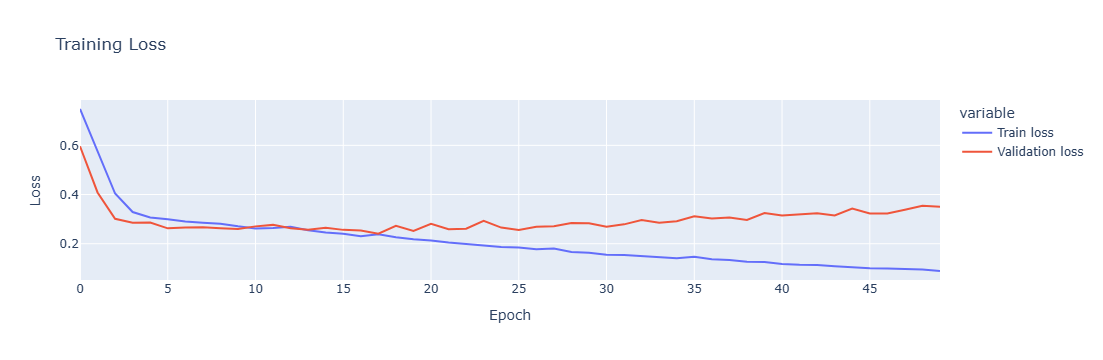

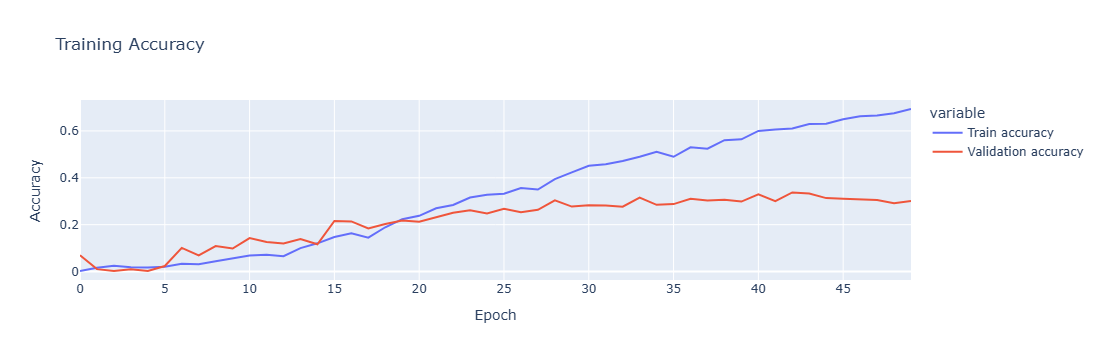

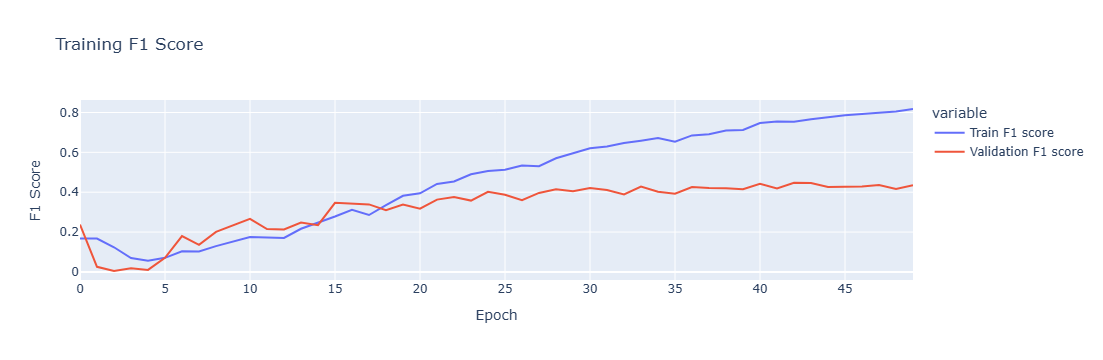

In [39]:
fig = px.line(pd.DataFrame({'Train loss': train_metrics.get('train_loss'), 'Validation loss': train_metrics.get('validation_loss')}), title="Training Loss")
fig.update_xaxes(title="Epoch")
fig.update_yaxes(title="Loss")
fig.show()

fig = px.line(pd.DataFrame({'Train accuracy': train_metrics.get('train_accuracy'), 'Validation accuracy': train_metrics.get('validation_accuracy')}), title="Training Accuracy")
fig.update_xaxes(title="Epoch")
fig.update_yaxes(title="Accuracy")
fig.show()

# Plot F1 if present
if 'train_f1' in train_metrics:
    fig = px.line(pd.DataFrame({'Train F1 score': train_metrics.get('train_f1'), 'Validation F1 score': train_metrics.get('validation_f1')}), title="Training F1 Score")
    fig.update_xaxes(title="Epoch")
    fig.update_yaxes(title="F1 Score")
    fig.show()

### Evaluate the classifier

The function below returns the testing loss, F1 score, accuracy and multi-label confusion matrices.

In [40]:
def evaluate_model(model, test_data, prediction_threshold=0.5, weighted_loss=True, class_weights=None):
    
    """ 
    Calculate testing loss, F1 score, accuracy and confusion matrix
    
    Parameters:
        model: the classifier network
        test_data: iterator for test batches
        prediction_threshold: the number that must be exceedd to predict a binary label
        weighted_loss: use weighted version of loss function
    
    Return:
        metrics: a dictionary of metrics for testing performance, e.g. 'test_loss'
    
    """
    
    # Record loss
    test_loss, test_f1, test_accuracy = 0, 0, 0
    # Record all predictions
    all_predicted = []
    all_true = []
    
    # Put model into evaluation mode
    model.eval()
    batch_count = 0
    
    # Disable gradient calculation
    with torch.no_grad():
        for batch in test_data:
            batch_count += 1
            text, text_lengths = batch.text
            # Make prediction for label probabilities
            prediction = model(text, text_lengths)
            true_labels = batch.label
            # Find the top predicted labels from probabilities
            predicted_labels = torch.tensor([[1 if value > prediction_threshold else 0 for value in sample] for sample in prediction])
            # Create weights for loss function
            if weighted_loss:
                weights = create_weights(true_labels, prediction, predicted_labels, prediction_threshold, class_weights=class_weights)
            else:
                weights = torch.ones(len(prediction), len(prediction[0])).to(device)
            # Calculate loss
            loss = F.binary_cross_entropy(prediction, true_labels, weight=weights)
            test_loss += loss.item()
            if not 1 in predicted_labels:
                # Prevent no labels being predicted
                best_label = prediction.argmax(1)[0].item()
                predicted_labels[0][best_label] = 1
            for pred, true in zip(predicted_labels, true_labels.cpu()):
                all_predicted.append(np.array(pred))
                all_true.append(np.array(true))
            #print(binary_encoder.inverse_transform(true_labels.cpu()))
            f1 = f1_score(predicted_labels, true_labels.cpu(), average='micro', zero_division=1)
            accuracy = accuracy_score(predicted_labels, true_labels.cpu())
            test_f1 += f1
            test_accuracy += accuracy
            
    # Confusion matrix
    conf_matrix = multilabel_confusion_matrix(all_predicted, all_true)

    # Calculate average loss, f1 and accuracy across all batches
    test_loss = test_loss/batch_count
    test_f1 = test_f1/batch_count
    test_accuracy = test_accuracy/batch_count
    
    metrics = {"loss": test_loss, "f1": test_f1, "accuracy": test_accuracy, "confusion_matrix": conf_matrix}
    
    return metrics

Test the classifier's performance on unseen data. The state of the model to load can be changed through setting `model_state_to_load`:
* To use the last state of the model, set as `final_state_file`.
* To use the state with the highest validation accuracy / lowest loss, set as `best_state_file`.
* Alternatively to test another pre-trained model, set as the file path for the model.

In [41]:
model_state_to_load = best_state_file

# Load the best model weights
lstm_model.load_state_dict(torch.load(model_state_to_load))

# Test performance
test_metrics = evaluate_model(lstm_model, test_iterator, prediction_threshold=label_threshold)

print(colored("Test loss: ", color="blue", attrs=['bold']) + str(round(test_metrics.get('loss'), 3)))
print(colored("Test f1 score: ", color="blue", attrs=['bold']) + str(round(test_metrics.get('f1'), 3)))
print(colored("Test accuracy: ", color="blue", attrs=['bold']) + str(round(test_metrics.get('accuracy') * 100, 3)) + "%")

Test loss: 0.533
Test f1 score: 0.43
Test accuracy: 30.937%


###### Confusion matrix

Plot confusion matrices for each genre. These show:
* True negatives: not predicted and correct (top left)
* False positives: predicted but not correct (top right)
* False negatives: not predicted and not correct (lower left)
* True positives: predicted and correct (lower right)

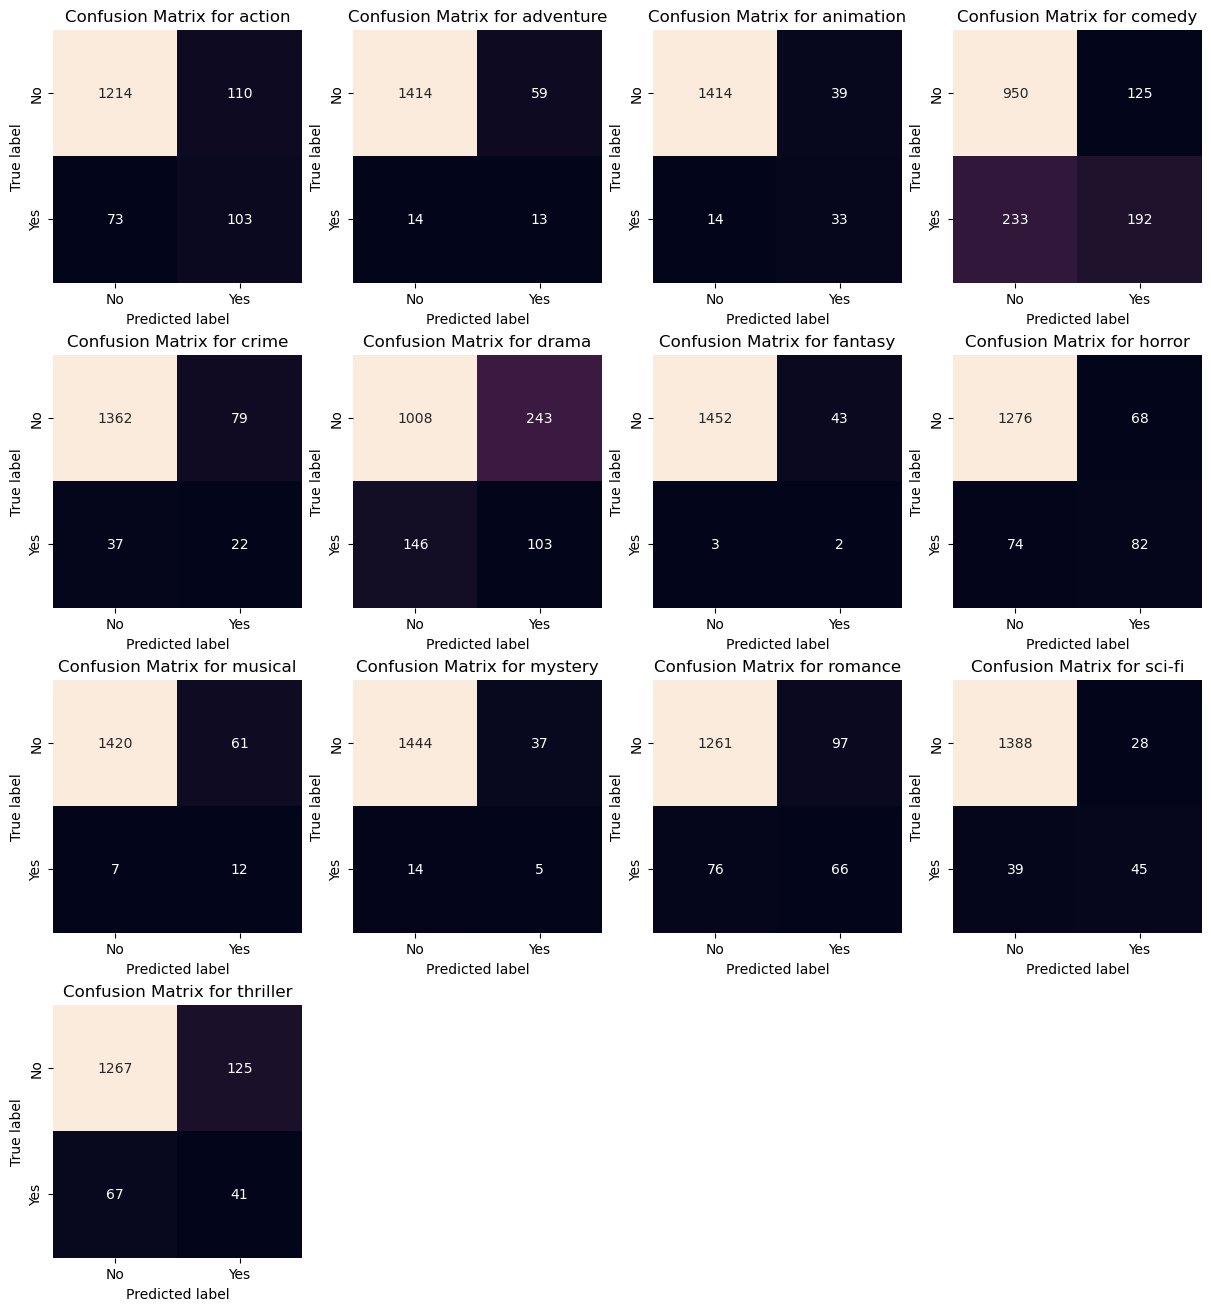

In [42]:
fig, ax = plt.subplots(math.ceil(len(sampled_unique_genres) / 4), 4, figsize=(12, math.ceil(len(sampled_unique_genres))), constrained_layout=True)

for matrix, axis, gen in zip(test_metrics.get('confusion_matrix'), ax.flatten(), sampled_unique_genres):
    # Create a plot for each genre
    matrix_df = pd.DataFrame(matrix, index=["No", "Yes"], columns=["No", "Yes"])
    heatmap = sns.heatmap(matrix_df, annot=True, fmt="d", cbar=False, ax=axis)
    axis.set_title("Confusion Matrix for " + gen, fontsize=12)
    axis.set_ylabel('True label')
    axis.set_xlabel('Predicted label')

# Hide unused axes
for i in range(1, (math.ceil(len(sampled_unique_genres) / 4) * 4) - len(sampled_unique_genres) + 1):
    ax[-1, -1 * i].axis('off')
    
plt.show()

### Prediction

The function below takes a custom text input, pre-processes the text, converts it into a form suitable for the classifier and returns the predicted genres.

In [43]:
def make_prediction(model, user_text, torchtext_TEXT, prediction_threshold=0.5):
    # Put model in evaluation mode
    model.eval()
    
    # Process text and convert into words
    sentences = process_text_samples(data=[user_text], stop_list=stop_words, lemmatize=True)
    words = []
    for sent in sentences[0]:
        for word in sent:
            words.append(word)
            
    # Get indexes of tokens
    token_indexes = [torchtext_TEXT.vocab.stoi[token] for token in words]
    # Convert indexes to tensor
    token_tensor = torch.LongTensor(token_indexes).to(device)
    # Add extra dimension to shape to replicate batch
    token_tensor = token_tensor.unsqueeze(1)
    # Get the length of the text
    length_tensor = torch.LongTensor([len(token_indexes)])
    
    # Make a prediction
    prediction = model(token_tensor, length_tensor)
    # Convert model outputs to binary labels, then to genre
    predicted_labels = torch.tensor([[1 if value > prediction_threshold else 0 for value in sample] for sample in prediction])
    if not 1 in predicted_labels:
        # Prevent no labels being predicted
        best_label = prediction.argmax(1)[0].item()
        predicted_labels[0][best_label] = 1
    predicted_categories = binary_encoder.inverse_transform(predicted_labels.cpu())
    
    return predicted_categories

Enter an IMDb film / series description and see the predicted genre(s).

For example:
* "The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe."
* "A group of young adults visit a boarded up campsite named Crystal Lake where they soon encounter the mysterious Jason Voorhees and his deadly intentions."
* "Comedy following the exploits of Det. Jake Peralta and his diverse, lovable colleagues as they police the NYPD's 99th Precinct."
* "While navigating their careers in Los Angeles, a pianist and an actress fall in love while attempting to reconcile their aspirations for the future."
* "Sheriff Deputy Rick Grimes wakes up from a coma to learn the world is in ruins and must lead a group of survivors to stay alive."
* "A young woman, traumatized by a tragic event in her past, seeks out vengeance against those who crossed her path."
* "Stuck in a time loop, two wedding guests develop a budding romance while living the same day over and over again."

In [63]:
'''example_description = ""

while example_description != "end":
    example_description = input("Description: ")
    if example_description != "end":
        predicted_gen = make_prediction(lstm_model, example_description, torchtext_TEXT=TEXT, prediction_threshold=label_threshold)
        print("Prediction: " + str(predicted_gen[0]) + "\n")'''

'example_description = ""\n\nwhile example_description != "end":\n    example_description = input("Description: ")\n    if example_description != "end":\n        predicted_gen = make_prediction(lstm_model, example_description, torchtext_TEXT=TEXT, prediction_threshold=label_threshold)\n        print("Prediction: " + str(predicted_gen[0]) + "\n")'

In [62]:
test_plots = np.load('data/X_test.npy', allow_pickle=True).tolist()
test_values = np.load('data/y_test.npy').tolist()

name_arr = []
for i in range(len(test_plots)):
    name_arr.append(i)

test_indices = [[i for i, x in enumerate(row) if x == 1] for row in test_values]
#print(indices)
test_genre_arr = []
for index_arr in test_indices:
    genre = ""
    for gen in index_arr:
        genre += genre_map.get(gen + 1) + ", "
    genre = genre.strip()
    genre = genre[:-1]
    test_genre_arr.append(genre)
    
print(len(test_plots), len(test_genre_arr), len(name_arr))

#print(test_genre_arr)
#print(test_plots[0])

predicted_gen = make_prediction(lstm_model, test_plots[0], torchtext_TEXT=TEXT, prediction_threshold=label_threshold)
print(predicted_gen[0][0])

#print(test_indices)

num_correct = 0
for i in range(len(test_plots)):
    predicted_gen = make_prediction(lstm_model, test_plots[i], torchtext_TEXT=TEXT, prediction_threshold=label_threshold)[0][0]
    if predicted_gen in test_genre_arr[i].split(", "):
        num_correct += 1

print(num_correct)



4598 4598 4598
action
2192
